# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [30]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType, BooleanType

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [11]:
dataset_path = "data/mini_sparkify_event_data.json"

In [12]:
df = spark.read.json(dataset_path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [13]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Let's define the churn function that will find set 1 when row means churn and 0 otherwise. To find a churn we'll use the `page` when `Downgrade` and `Cancellation Confirmation` event happened.

In [14]:
def churn(value):
    if value == "Downgrade" or value == "Cancellation Confirmation":
        return 1
    return 0

Now let's apply this function our dataframe.

In [15]:
setChurn = udf(churn, IntegerType())
df = df.withColumn("churn", setChurn(df.page))

So now let's take churned users id's and let's put them to separate collection. First let's collect id of users that left our service by reasons.

In [16]:
churned_ids = df.filter(df.churn == 1).select("userId").dropDuplicates().collect()
churned_ids = [i.userId for i in churned_ids]

Now let's define two functions that will find users that are churned and not churned.

In [17]:
isInChurn = udf(lambda x: x in churned_ids, BooleanType())
notInChurn = udf(lambda x: x not in churned_ids, BooleanType())

### How many users churned from the service?

In [18]:
print("Number of churned users: {}".format(df.filter(isInChurn(df.userId)).select("userId").dropDuplicates().count()))
print("Number of staying users: {}".format(df.filter(notInChurn(df.userId)).select("userId").dropDuplicates().count()))

Number of churned users: 171
Number of staying users: 55


So it looks like for the sparkify mini event data more users had events `Downgraded` or `Cancellation Confirmation` rather than users which didn't take that options, however there can be users that returned to the service after leaving it (downgraded from premium and then came back for example).

### Do we have null values across the dataset?

Now as we have simple churn defined, let's take a look more on how the dataset looks llike. First let's see which column has a null value and how much of these values are there

In [19]:
for column in df.columns:
    print("Column {} contains {} null values".format(column, df.where(col(column).isNull()).count()))

Column artist contains 58392 null values
Column auth contains 0 null values
Column firstName contains 8346 null values
Column gender contains 8346 null values
Column itemInSession contains 0 null values
Column lastName contains 8346 null values
Column length contains 58392 null values
Column level contains 0 null values
Column location contains 8346 null values
Column method contains 0 null values
Column page contains 0 null values
Column registration contains 8346 null values
Column sessionId contains 0 null values
Column song contains 58392 null values
Column status contains 0 null values
Column ts contains 0 null values
Column userAgent contains 8346 null values
Column userId contains 0 null values
Column churn contains 0 null values


So it looks like some of the values are nulls. We can see that number of different values are the same across all columns, let's see what can be cause of this situation.

Let's check if the same number null values have correclation with columns.

In [20]:
df.select("page").where((col("artist").isNull()) | (col("length").isNull()) | (col("song").isNull())).dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

So these pages are not connected with playing a song at all, that's then understandable why the 'artist', 'length' and 'song' columns contain null values - they are not existing is such situation.

Now let's see the columns for first and last name, gender and userAgent.

In [21]:
df.select("page").where((col("firstName").isNull()) | (col("gender").isNull()) | (col("lastName").isNull()) | (col("location").isNull()) | (col("registration").isNull()) | (col("userAgent").isNull())).dropDuplicates().collect()

[Row(page='Home'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Help'),
 Row(page='Error')]

So the reason why these columns contains null values is that, the events are connected to the operations done by the users out of the logged session.

So now let's group users by their id with events sorted by timestamps

In [22]:
users_by_id = []
user_ids = df.select("userId").dropDuplicates().collect()
i = 1
for row in user_ids:
    print("Processing {} out of {}".format(i, len(user_ids)))
    users_by_id.append(df.select("*").where(col("userId") == row.userId).sort('ts').collect())
    i += 1

Processing 1 out of 226
Processing 2 out of 226
Processing 3 out of 226
Processing 4 out of 226
Processing 5 out of 226
Processing 6 out of 226
Processing 7 out of 226
Processing 8 out of 226
Processing 9 out of 226
Processing 10 out of 226
Processing 11 out of 226
Processing 12 out of 226
Processing 13 out of 226
Processing 14 out of 226
Processing 15 out of 226
Processing 16 out of 226
Processing 17 out of 226
Processing 18 out of 226
Processing 19 out of 226
Processing 20 out of 226
Processing 21 out of 226
Processing 22 out of 226
Processing 23 out of 226
Processing 24 out of 226
Processing 25 out of 226
Processing 26 out of 226
Processing 27 out of 226
Processing 28 out of 226
Processing 29 out of 226
Processing 30 out of 226
Processing 31 out of 226
Processing 32 out of 226
Processing 33 out of 226
Processing 34 out of 226
Processing 35 out of 226
Processing 36 out of 226
Processing 37 out of 226
Processing 38 out of 226
Processing 39 out of 226
Processing 40 out of 226
Processin

Now when we have these users in place let's spli them to two sub-groups:
* Users that churned
* Users that stayed

### How churn rate distribute over genders?

Let's see which users of which gender are more likely to churn. First let's get the dataframe of churn users.

In [59]:
users_gender=df.filter(isInChurn(df.userId)).select("userId", "gender", "churn").dropDuplicates(["userId"]).toPandas()
users_gender.head()

,userId,gender,churn
0,200002,M,0
1,125,M,0
2,124,F,0
3,51,M,0
4,15,M,0


But what is it? The `churn` column contains 0? Indeed it's because we filter out the users with Id's that performed downgrade of the account and due to `dropDuplicates()` the information about churn for downgrade was missed. Let's fix it for the sake of answering the question.

In [60]:
users_gender["churn"] = 1
users_gender.head()

,userId,gender,churn
0,200002,M,1
1,125,M,1
2,124,F,1
3,51,M,1
4,15,M,1


In [61]:
users_gender = pd.concat([users_gender,\
                                   df.filter(notInChurn(df.userId)).select("userId", "gender", "location", "churn").dropDuplicates(["userId"]).toPandas()], axis=0)

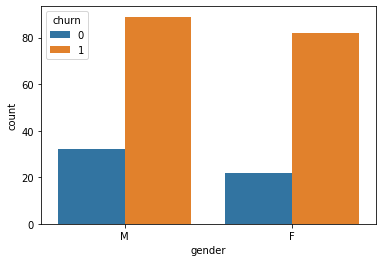

In [62]:
plt.clf()
ax = sns.countplot(x="gender", hue="churn", data=users_gender)
plt.show()

So we can see that there are slightly more male users that churn from the service. Now let's clear this pandas dataframe.

In [66]:
users_gender.drop(users_gender.index, inplace=True)

### How many song users are listening to before churn?

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.